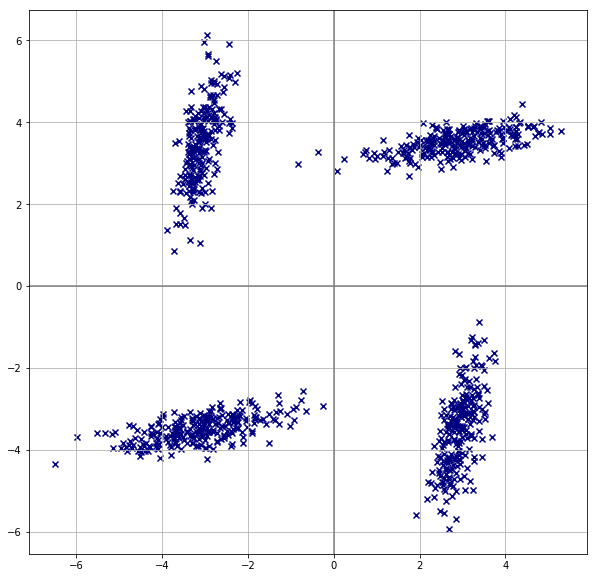

In [44]:
import numpy as np
import matplotlib.pyplot as plt
#from tools import dist_m

import matplotlib.colors as pltcolors

plt.rcParams['figure.figsize'] = [10, 10]

data = np.genfromtxt('data5.txt', delimiter=' ')

#data_temp = np.zeros(data.shape)
#data_temp[:,0] = np.linalg.norm(data,axis=1)
#data_temp[:,1] = np.arctan2(data[:,1], data[:,0]) #np.arccos(data[:,0]/data_temp[:,0])
#data_temp[:,1] = data_temp[:,1] + np.pi/4
#data[:,0] = 2*data_temp[:,0]*np.cos(data_temp[:,1])
#data[:,1] = 2*data_temp[:,0]*np.sin(data_temp[:,1])
#data = data + np.array([12,10])

#normalizace dat - střední hodnota = [0,0]
me = np.mean(data, axis=0)
data = data - me
#data = data + np.array([3,4])

# najití maxima/minima v obou osách
lim_v = np.array([np.abs(np.amax(data[:,0])),
                  np.abs(np.amin(data[:,0])),
                  np.abs(np.amax(data[:,1])),
                  np.abs(np.amin(data[:,1]))])
lim = np.amax(lim_v) + np.amax(lim_v)*.1

plt.scatter(data[:,0],data[:,1], color='navy', marker='x')
plt.grid(True, which='both')
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

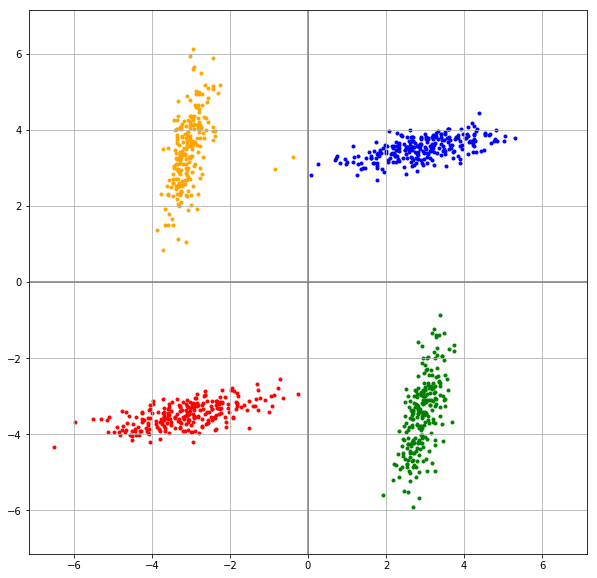

In [45]:
#výpočet počtu tříd
from maximin import maximin
x = np.zeros(100)
mm = lambda t: maximin(data)
vfunc = np.vectorize(mm)
x = vfunc(x)
cl_nb = int(np.ceil(np.mean(x)))

# rozdělení dat do tříd
from kmeans import kmeans_direct, iterative_optim, kmeans_binary, plot_kmeans_result
#from tools import plot_result

eps = 1.e-03 #nastavení zastavovací podmínky

# přímé dělení
data_classified = kmeans_binary(data, cl_nb, eps)
data_classified = iterative_optim(data_classified, cl_nb)
plot_kmeans_result(data_classified, lim)

In [11]:
###### Rossenblatt ########

def rosenblatt(data):
    # přidání 1 na začátek všech dat
    w_data = []
    for i in range(cl_nb):
        ones = np.ones((len(data[i]),1))
        w_data.append(np.concatenate((ones,data[i]),axis=1))

    # vytvoření prázdné matice prvků diskriminačních funkcí fí
    fi = []
    for i in range(cl_nb): #n
        fi.append([])
        for c in range(cl_nb): 
            fi[i].append(np.array([1,1,1])) # vzhledem k tomu, že jsou data centrovaná kolem (0,0), počáteční aproximace je [0,0,0] 

    #napočítání jednotlivých fí funkcí
    # dodělat kontrolu, jestli jsou všechny body v pořádku. Pokud ne, opakovat výpočet
    ndone = True
    max_iter = 100
    cnt = 0
    iter_cnt=0
    
#    while ndone and cnt <= max_iter:
#        cnt += 1
    for i in range(cl_nb-1):
        for j in range(i+1, cl_nb):
            ndone = True
            while ndone and cnt <= max_iter: 
                min_len=np.amin([len(w_data[j]),len(w_data[i])])
                min_pos=np.argmin([len(w_data[j]),len(w_data[i])])

                for n in range(min_len):
                    if np.dot(fi[i][j],w_data[j][n,:].T) >= 0:
                        fi[i][j] = fi[i][j] + (-1)*w_data[j][n,:]
                    if np.dot(fi[i][j],w_data[i][n,:].T) < 0:
                        fi[i][j] = fi[i][j] + w_data[i][n,:]
                iter_cnt += min_len
                if min_pos == 0:
                    max_pos = i
                    z = 1
                else:
                    max_pos = j
                    z = -1
                for n in range(min_len, len(w_data[max_pos])):
                    if np.dot(fi[i][j],w_data[max_pos][n,:].T)*z <= 0:
                        fi[i][j] = fi[i][j] + z*w_data[max_pos][n,:]
                iter_cnt += len(w_data[max_pos])-min_len
                fi[j][i] = -1*fi[i][j]

                #kontrola, zda jsou všechna trénovací data správně klasifikována
                #ndone = False
                #for n in range(len(w_data[i])):
                #    if np.dot(fi[i][j],w_data[i][n,:].T) < 0:
                #        ndone = True
                #        break 
                        
                
                ndone = False
                for n in range(len(w_data[i])):
                    if np.dot(fi[i][j],w_data[i][n,:].T) <= 0:
                        ndone = True
                        cnt += 1
                        break
                for n in range(len(w_data[j])):
                    if np.dot(fi[i][j],w_data[j][n,:].T) > 0:
                        ndone = True
                        cnt += 1
                        break

    print(iter_cnt)
    print(cnt)
    return fi

Zdá se, že metoda konstatního přírustku (a tím i modifikovaná metoda konstatního přírustku) se chová stejně jako Rossenblatt. Ať násobím jakýmikoliv koeficienty, tak nepotřebuju jiný počet iterací než jen jeden průchod. Podle mě je to tímto:
- data jsou normalizovaná a mají střed v 0,0
- díky tomu začínám se startovací aproximací 0,0,0
- trénovací data procházím cik-cak - vždycky jedno dato které do třídy patří, jedno které ne

Mám implementovat i další algoritmy, nebo tohle stačí?



In [60]:
### Metoda konstantního přírustku

def norm_x(x):
    return x[0]**2+x[1]**2+x[2]**2

def konstantni_prirustek(data):
    beta = 1.
    delta = 0. # pásmo necitlivosti
    # přidání 1 na začátek všech dat
    w_data = []
    for i in range(cl_nb):
        ones = np.ones((len(data[i]),1))
        w_data.append(np.concatenate((ones,data[i]),axis=1))

    # vytvoření prázdné matice prvků diskriminačních funkcí fí
    fi = []
    for i in range(cl_nb): #n
        fi.append([])
        for c in range(cl_nb): 
            fi[i].append(np.array([0,0,0])) # vzhledem k tomu, že jsou data centrovaná kolem (0,0), počáteční aproximace je [0,0,0] 

    #napočítání jednotlivých fí funkcí
    # dodělat kontrolu, jestli jsou všechny body v pořádku. Pokud ne, opakovat výpočet
    ndone = True
    max_iter = 100
    cnt = 0
    iter_cnt = 0
    
    
    #for ghj in range(20):    
    for i in range(cl_nb-1):
        for j in range(i+1, cl_nb):
            ndone = True
            while ndone and cnt <= max_iter: 
                min_len=np.amin([len(w_data[j]),len(w_data[i])])
                min_pos=np.argmin([len(w_data[j]),len(w_data[i])])

                for n in range(min_len):
                    #print(min_len)
                    if np.dot(fi[i][j],w_data[j][n,:].T) >= 0:
                    #while np.dot(fi[i][j],w_data[j][n,:].T) >= 0:
                        #bk = np.floor((delta+np.dot(fi[i][j],w_data[j][n,:].T))/beta)
                        #print(np.dot(fi[i][j],w_data[j][n,:].T))
                        ck = beta/norm_x(w_data[j][n,:])
                        fi[i][j] = fi[i][j] + ck*(-1)*w_data[j][n,:]
                        iter_cnt = iter_cnt + 1
                        #print(iter_cnt)
                    if np.dot(fi[i][j],w_data[i][n,:].T) < 0:
                    #while np.dot(fi[i][j],w_data[i][n,:].T) < 0:
                        #bk = np.floor((delta-np.dot(fi[i][j],w_data[i][n,:].T))/beta)
                        ck = beta/norm_x(w_data[i][n,:])
                        fi[i][j] = fi[i][j] + ck*w_data[i][n,:] 
                        iter_cnt += 1
                #iter_cnt += min_len
                if min_pos == 0:
                    max_pos = i
                    z = 1
                else:
                    max_pos = j
                    z = -1
                # kontroluju zbylá data
                for n in range(min_len, len(w_data[max_pos])):
                    if np.dot(fi[i][j],w_data[max_pos][n,:].T)*z < 0:
                    #while np.dot(fi[i][j],w_data[max_pos][n,:].T)*z <= 0:
                        #bk = np.floor(((delta-np.dot(fi[i][j],w_data[max_pos][n,:].T))*z)/beta)
                        ck = beta/norm_x(w_data[max_pos][n,:])
                        fi[i][j] = fi[i][j] + ck*z*w_data[max_pos][n,:]
                        iter_cnt += 1
                #iter_cnt += len(w_data[max_pos])-min_len
                fi[j][i] = -1*fi[i][j]
                

                ndone = False
                for n in range(len(w_data[i])):
                    if np.dot(fi[i][j],w_data[i][n,:].T) <= 0:
                        ndone = True
                        cnt += 1
                        break
                for n in range(len(w_data[j])):
                    if np.dot(fi[i][j],w_data[j][n,:].T) > 0:
                        ndone = True
                        cnt += 1
                        break

    print(iter_cnt)
    print(cnt)
    return fi

20
4
[[array([0, 0, 0]), array([ 0.04351889, -0.43624099,  0.01819111]), array([-0.03070777, -0.1361706 , -0.10593569]), array([-0.02881209,  0.07577276, -0.14913229])], [array([-0.04351889,  0.43624099, -0.01819111]), array([0, 0, 0]), array([ 0.00263048, -0.02720939, -0.24860406]), array([-0.02881209,  0.07577276, -0.14913229])], [array([0.03070777, 0.1361706 , 0.10593569]), array([-0.00263048,  0.02720939,  0.24860406]), array([0, 0, 0]), array([0.05430458, 0.70321118, 0.05613361])], [array([ 0.02881209, -0.07577276,  0.14913229]), array([ 0.02881209, -0.07577276,  0.14913229]), array([-0.05430458, -0.70321118, -0.05613361]), array([0, 0, 0])]]


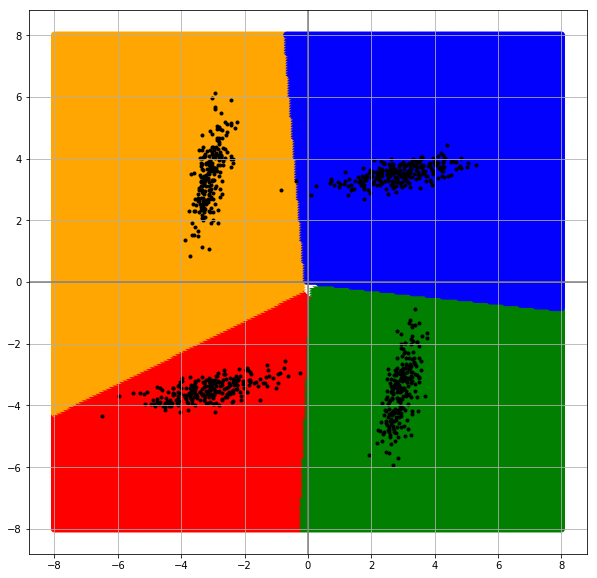

In [61]:
############################

#kontrola --> možná použít tensordot (nasobení vektoru a matice (podle os))

#vykreslení

# vytvořit meshgrid
grid_dim = 300
X,Y = np.meshgrid(np.linspace(-8,8,grid_dim),np.linspace(-8,8,grid_dim))

Z = np.zeros((grid_dim,grid_dim))

#fi = rosenblatt(data_classified)
fi = konstantni_prirustek(data_classified)
print(fi)
for x in range(grid_dim):
    for y in range(grid_dim):
        fi_mx = np.zeros((cl_nb,cl_nb))
        for i in range(cl_nb):
            for j in range(cl_nb):
                fi_mx[i,j] = np.sign(np.dot(fi[i][j],[1,X[x,y],Y[x,y]]))
        np.fill_diagonal(fi_mx,0) 

        fi_mx_sum_p = np.where(np.sum(fi_mx,axis=1) >= 3.)
        if len(fi_mx_sum_p[0])==1:
            Z[x,y] = fi_mx_sum_p[0]
        else:
            Z[x,y] = 4
        
cmap = pltcolors.LinearSegmentedColormap.from_list('', ['red','green','blue','orange', 'white'])
norm=plt.Normalize(0,4)
plt.scatter(X,Y,c=Z, cmap=cmap, norm=norm)

plt.scatter(data[:,0],data[:,1], color='black', marker='.')

plt.grid(True, which='both')
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.show()

In [53]:
#for i in range(len(w_data[3])):
#    print(np.dot(q[3],w_data[3][i,:].T))

np.sign(00)

0

In [35]:
z = 1 if 1>1 else -1
print(z)

-1


In [63]:
m = np.array([1,0,-1,0])
np.sum(m == 0)

2

In [76]:
fi = []
for i in range(cl_nb-1): #n
    fi.append([])
    for c in range(cl_nb-1): 
        fi[i].append(np.array([1,1,1]))
print(fi)

[[array([1, 1, 1]), array([1, 1, 1]), array([1, 1, 1])], [array([1, 1, 1]), array([1, 1, 1]), array([1, 1, 1])], [array([1, 1, 1]), array([1, 1, 1]), array([1, 1, 1])]]


In [180]:
a = np.zeros((3, 3), int)
np.fill_diagonal(a, 5)
print(a)

[[5 0 0]
 [0 5 0]
 [0 0 5]]


In [218]:

fi_mx_sum = np.array([1,3,2,3,2,3])
print(fi_mx_sum)
fi_mx_sum_p = np.where(fi_mx_sum >= 3)
print(fi_mx_sum_p)

[1 3 2 3 2 3]
(array([1, 3, 5]),)
